In [4]:
# check for cuda and python version 
import os, sys

print(os.environ['LD_LIBRARY_PATH'])
print(sys.version)

/home/yhc/cuda/lib64:/usr/local/cuda-11.2/lib64
3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]


In [5]:
# Check for using gpu
import tensorflow as tf

print(tf.test.gpu_device_name())
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

/device:GPU:0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Tutorial: Ground State of 1D Transverse-field Ferromagnetic Ising Model (TFIM) with RNN wavefunctions

Code by **Mohamed Hibat Allah** and **Martin Ganahl**.



**This notebook is intended to help the reader to get familiarized with Exact Diagonalization (ED) and Positive Recurrent Neural Networks (pRNN) wavefunctions. Here, we just explore small system sizes for pedagogical purposes and to keep the running time very short.**


Check if you specifying the right "path" below to the google colab notebook on Drive to make sure everything below is working properly

Make sure also you use a GPU by going to "Runtime/Change Runtime type" in Google Colaboratory to get a speedup

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['axes.labelsize']  = 20
rcParams['font.serif']      = ['Computer Modern']
rcParams['font.size']       = 10
rcParams['legend.fontsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

## **Calculating the ground state energy of 1DTFIM using Exact Diagonalization (ED)**

Here, we attempt to calculate the ground state and the ground state energy of the 1D Transverse field Ising Model with Open Boundary Conditions using Exact diagonalization.

The Hamiltonian is given as follows:

$$\hat{H}_{\text{TFIM}} = - \sum_{\langle i,j \rangle} \hat{\sigma}^{z}_i \hat{\sigma}^{z}_j - B_x \sum_{i} \hat{\sigma}^{x}_i $$

where ${\bf \sigma}_i$ are pauli matrices.  Here,
$\langle i,j \rangle$ denote
nearest neighbor pairs.

In [7]:
def IsingMatrixElements(Jz,Bx,sigmap):
    """
    computes the matrix element of the open Ising Hamiltonian for a given state sigmap
    -----------------------------------------------------------------------------------
    Parameters:
    Jz: np.ndarray of shape (N), respectively, and dtype=float:
                Ising parameters
    sigmap:     np.ndarrray of dtype=int and shape (N)
                spin-state, integer encoded (using 0 for down spin and 1 for up spin)
                A sample of spins can be fed here.
    Bx: Transvers magnetic field (N)
    -----------------------------------------------------------------------------------            
    Returns: 2-tuple of type (np.ndarray,np.ndarray)
             sigmas:         np.ndarray of dtype=int and shape (?,N)
                             the states for which there exist non-zero matrix elements for given sigmap
             matrixelements: np.ndarray of dtype=float and shape (?)
                             the non-zero matrix elements
    """
    #the diagonal part is simply the sum of all Sz-Sz interactions
    diag=0
    
    sigmas=[]
    matrix_elements=[]
    N = Jz.shape[0]
    
    for site in range(N-1):
        if sigmap[site]==sigmap[site+1]: #if the two neighouring spins are the same (We use open Boundary Conditions)
            diag-=Jz[site] #add a negative energy contribution (We use ferromagnetic couplings)
        else:
            diag+=Jz[site]
            
    matrix_elements.append(diag)
    sigmas.append(sigmap)
    
    #off-diagonal part (For the transverse Ising Model)
    for site in range(N):
        if Bx[site] != 0:
            sig = np.copy(sigmap)
            sig[site]=np.abs(1-sig[site])
            matrix_elements.append(-Bx[site])
            sigmas.append(sig)    

    return np.array(sigmas),np.array(matrix_elements)

def ED_1DTFIM(N=10, h = 1):
    """
    Returns a tuple (eta,U)
        eta = a list of energy eigenvalues.
        U = a list of energy eigenvectors
    """
    Jz=+np.ones(N)
    Bx=+h*np.ones(N)

    basis = []
    #Generate a z-basis
    for i in range(2**N):
        basis_temp = np.zeros((N))
        a = np.array([int(d) for d in bin(i)[2:]])
        l = len(a)
        basis_temp[N-l:] = a
      
        basis.append(basis_temp)
    basis = np.array(basis)
      
    H=np.zeros((basis.shape[0],basis.shape[0])) #prepare the hamiltonian
    for n in range(basis.shape[0]):
        sigmas,elements=IsingMatrixElements(Jz,Bx,basis[n])
        for m in range(sigmas.shape[0]):
            for b in range(basis.shape[0]):
                if np.all(basis[b,:]==sigmas[m,:]):
                    H[n,b]=elements[m]
                    break
    eta,U=np.linalg.eigh(H) #diagonalize
    return eta,U


It may take some time to do exact diagonalization. You can try up to $N=12$ spins otherwise you have to wait for a very long time.

In [8]:
eta, U = ED_1DTFIM(N=10, h = 1)

print('The ground state energy is:')
print(min(eta))
E_exact = min(eta)

The ground state energy is:
-12.381489999654754


## **Representing the ground state**

Sometimes it is useful to represent the ground state in a plot as shown below, to know some information about the properties of the ground state, such as symmetries, sign of the amplitudes,...

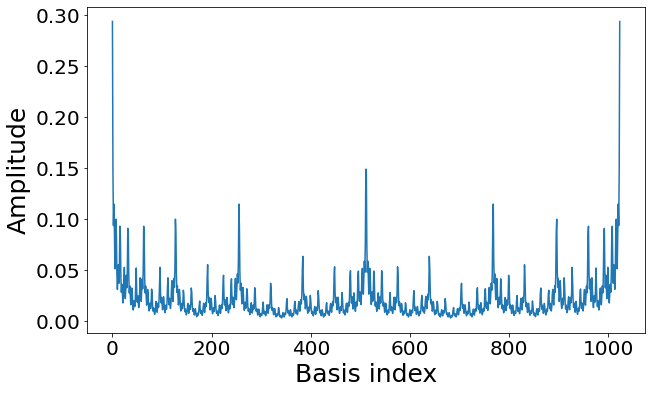

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

ground_state = -U[:,np.nonzero(eta==np.min(eta))[0][0]]

plt.plot(ground_state,label="Ground state")

ax.set_xlabel(r'Basis index', fontsize = 25)
ax.set_ylabel('Amplitude', fontsize = 25)

plt.show()

We notice here that the amplitudes of the ground state in the z-basis do not change sign, hence we can use a positive recurrent neural network wavefunction (pRNN wavefunction).

## **Calculating the ground state energy using an RNN wavefunction**

After that we obtained the ground state energy from exact diagonalization, we are going to value as a reference to assess the quality of the variational energy calculated by the pRNN wavefunction

In [10]:
from TrainingRNN_1DTFIM import run_1DTFIM


#numsteps = number of training iterations
#systemsize = number of physical spins
#Bx = transverse magnetic field
#numsamples = number of samples used for training
numsamples = 200
#num_units = number of memory units of the hidden state of the RNN
#num_layers = number of vertically stacked RNN cells

#This function trains a pRNN wavefunction for 1DTFIM with the corresponding hyperparams
RNNEnergy, varRNNEnergy = run_1DTFIM(numsteps = 1000, systemsize = 10, Bx = +1, num_units = 10,  num_layers = 1, numsamples = numsamples, learningrate = 5e-3, seed = 111)

#RNNEnergy is a numpy array of the variational energy of the pRNN wavefunction
#varRNNEnergy is a numpy array of the variance of the variational energy of the pRNN wavefunction

Instructions for updating:
non-resource variables are not supported in the long term
mean(E): -10.433355130871043, var(E): 7.554505341395473, #samples 200, #Step 0 


mean(E): -10.997085161898337, var(E): 5.307046785385284, #samples 200, #Step 10 


mean(E): -11.750835973278837, var(E): 1.7220849919789456, #samples 200, #Step 20 


mean(E): -11.91802251602204, var(E): 1.164333812602898, #samples 200, #Step 30 


mean(E): -11.986437589886783, var(E): 0.6440991550545011, #samples 200, #Step 40 


mean(E): -12.157110233196706, var(E): 0.3861546386182114, #samples 200, #Step 50 


mean(E): -12.217358478851267, var(E): 0.19877814343668235, #samples 200, #Step 60 


mean(E): -12.307471583176461, var(E): 0.1517041695617749, #samples 200, #Step 70 


mean(E): -12.321029396825361, var(E): 0.0922583579705151, #samples 200, #Step 80 


mean(E): -12.363066091592543, var(E): 0.12899715626189245, #samples 200, #Step 90 


mean(E): -12.353435604023106, var(E): 0.08437118973160022, #samples 200, #Step

mean(E): -12.376726193833173, var(E): 0.005143590990510702, #samples 200, #Step 920 


mean(E): -12.386491635717894, var(E): 0.0056093832558226754, #samples 200, #Step 930 


mean(E): -12.376057841636031, var(E): 0.005631738107227166, #samples 200, #Step 940 


mean(E): -12.380745279147199, var(E): 0.004468466020569665, #samples 200, #Step 950 


mean(E): -12.382872126254286, var(E): 0.004821901917193117, #samples 200, #Step 960 


mean(E): -12.379651217013343, var(E): 0.004564828202614831, #samples 200, #Step 970 


mean(E): -12.381764544987432, var(E): 0.0057392807760626744, #samples 200, #Step 980 


mean(E): -12.37776288854087, var(E): 0.005152658482739865, #samples 200, #Step 990 


mean(E): -12.378444600427065, var(E): 0.0039631777810658015, #samples 200, #Step 1000 




## **Comparison of RNN results with ED**

After we got the variational energies for each time step, we can now compare the RNN results with exact diagonalization

In [11]:
#Computing the ground state energy by taking average over the last 100 iterations
print("Ground state energy = ", np.mean(RNNEnergy[-100:]), "+-", np.sqrt(np.max(varRNNEnergy[-100:])/(numsamples*100))) #We use np.max(varRNNEnergy[-100:]) to estimate an upper bound on the error
print("Exact ground state energy = ", E_exact)

Ground state energy =  -12.380770326281763 +- 0.000667655289894823
Exact ground state energy =  -12.381489999654754


Amazing! We can also plot the variational energy and the energy variance where we observe convergence during the last iterations.

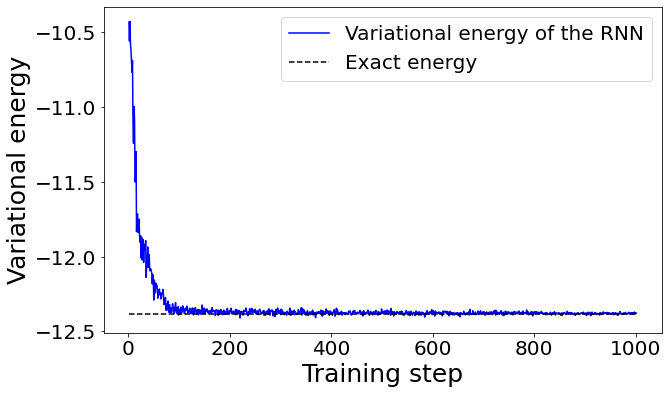

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.arange(1, len(RNNEnergy)+1), RNNEnergy, "b-", label="Variational energy of the RNN")
ax.plot(np.arange(1, len(RNNEnergy)+1), [E_exact]*len(RNNEnergy), "k--", label="Exact energy")

ax.set_xlabel(r'Training step', fontsize = 25)
ax.set_ylabel('Variational energy', fontsize = 25)
plt.legend()

plt.show()

### **Energy variance**

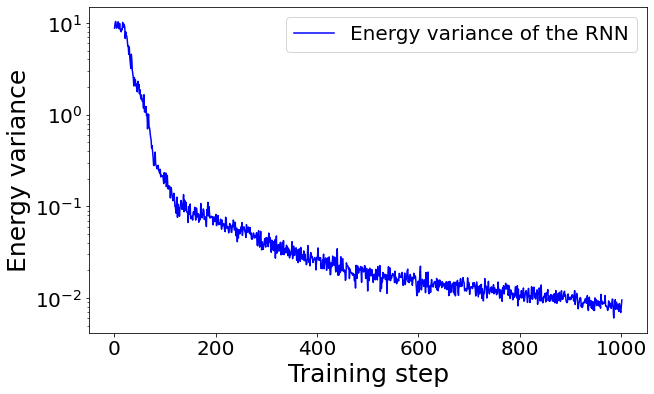

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

ax.semilogy(np.arange(1, len(RNNEnergy)+1), varRNNEnergy, "b-", label="Energy variance of the RNN")

ax.set_xlabel(r'Training step', fontsize = 25)
ax.set_ylabel('Energy variance', fontsize = 25)
plt.legend()

plt.show()

## **Explorations**

- If you want to explore large system sizes with the pRNN wavefunction, here are some ground states energy of 1DTFIM at the critical point (Bx = 1) given by DMRG and can be considered exact:


> N=20 : -25.1077971081

> N=30 : -37.8380982304

> N=40 : -50.5694337844

> N=50 : -63.3011891370

> N=60 : -76.0331561023

> N=70 : -88.7652446334

> N=80 : -101.4974094169

> N=90 : -114.2296251736

> N=100 : -126.9618766964

> N=1000 : -1272.8762945220

- You can also play with the hyperparameters (memory units, number of layers, number of samples, learning rate) to obtain better accuracies.

 

In [13]:
# test ploting

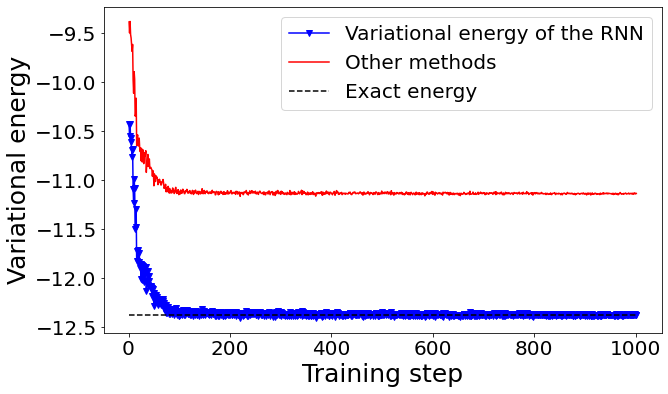

In [29]:
# plt is for plotting plots
fig, ax = plt.subplots(figsize=(10,6)) # (width, height)

# use "ax.plot" to draw lines
# ax.plot(x_values, y_values, style_of_line, optional_variables)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html
# see this ^ for styles of line
ax.plot(np.arange(1, len(RNNEnergy)+1), RNNEnergy, "vb-", label="Variational energy of the RNN")
ax.plot(np.arange(1, len(RNNEnergy)+1), [x*.9 for x in RNNEnergy], "r-", label="Other methods")
ax.plot(np.arange(1, len(RNNEnergy)+1), [E_exact]*len(RNNEnergy), "k--", label="Exact energy")

# descriptions for x and y axes
ax.set_xlabel(r'Training step', fontsize = 25)
ax.set_ylabel('Variational energy', fontsize = 25)
plt.legend() # print label

plt.show()